In [7]:
from io import BytesIO
from PIL import Image
import datasets
import joblib
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel
from sklearn.linear_model import LogisticRegression
import torch
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim
from matplotlib import pyplot as plt
import xgboost as xgb

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [8]:
# Load model and pre-processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)
vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
vision_model.to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [9]:
age_texts = [f"A person in the {c} age group" for c in ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]]

In [8]:
def get_embedding_and_zs(sample):
    # import pdb; pdb.set_trace()

    # Age prediction
    age_texts = [f"A person in the {c} age group" for c in ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]]
    inputs = processor(text=age_texts, images=sample["image"], return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    age_pred = logits_per_image.argmax(dim=1) # we can take the argmax
    
    sample["zs_age_clip"] = [int(gp) for gp in age_pred]
    # Store embeddings
    sample["embeddings"] = outputs.image_embeds
    
    
    return sample
    

In [10]:
# Load training data
train_ds = datasets.load_dataset('HuggingFaceM4/FairFace', '1.25', split='train', verification_mode="no_checks")
# train_ds = train_ds.shuffle(seed=42).select([i for i in range(1_000)]) # Take only first 20_000 images
train_ds = train_ds.shuffle(seed=42)
# train_ds = train_ds.map(get_embedding_and_zs, batched = True, batch_size=16)
# train_ds = train_ds.map(get_deepface_preds)

In [12]:
train_ds[0]["image"]
inputs = processor(images=train_ds[0]["image"], return_tensors="pt", padding=True).to(device)
outputs = vision_model(**inputs)

c:\Users\Debadyuti\.conda\envs\dissertation-env\lib\site-packages\transformers\models\clip\modeling_clip.py:480: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [16]:
outputs.pooler_output.shape

torch.Size([1, 768])

In [25]:
train_ds[5]["age"]

2

In [27]:
# Load validation data and test on this
test_valid_ds = datasets.load_dataset('HuggingFaceM4/FairFace', '1.25', split="validation", verification_mode="no_checks")
valid_ds = test_valid_ds.shuffle(seed=42).select([i for i in range(6_000)]) # Take only first 6_000 images'
test_ds = test_valid_ds.shuffle(seed=42).select([i for i in range(6_000, len(test_valid_ds))])
# valid_ds = valid_ds.shuffle(seed=42) 
valid_ds = valid_ds.map(get_embedding_and_zs, batched = True, batch_size=16)
test_ds = test_ds.map(get_embedding_and_zs, batched = True, batch_size=16)
# valid_ds = valid_ds.map(get_deepface_preds)

In [28]:
assert len(test_valid_ds) == len(test_ds) + len(valid_ds)

In [29]:
# # Load test data as second 50% of val split
# test_ds = datasets.load_dataset('HuggingFaceM4/FairFace', '1.25', split="validation[50%:]", verification_mode="no_checks")
# test_ds = test_ds.shuffle(seed=42).select([i for i in range(6_000)]) # Take only first 6_000 images
# test_ds = test_ds.map(get_embedding_and_zs, batched = True, batch_size=16)

In [30]:
train_ds

Dataset({
    features: ['image', 'age', 'gender', 'race', 'service_test', 'zs_age_clip', 'embeddings'],
    num_rows: 86744
})

In [31]:
# import tensorflow as tf
# tf.__version__

In [74]:
X_train = np.array(train_ds["embeddings"])
y_train_age = np.array(train_ds["age"])

In [75]:
X_val = np.array(valid_ds["embeddings"])
y_val_age = np.array(valid_ds["age"])

In [76]:
X_train[0].shape

(512,)

# Tree-based exploration

In [77]:
# Store the data as a DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_age)
dval = xgb.DMatrix(X_val, label=y_val_age)

In [1]:
# Hyperparameters
param = {'max_depth': 8, 'eta': 0.3, 'objective': 'multi:softmax'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
param["num_class"] = 9

In [2]:
evallist = [(dtrain, 'train'), (dval, 'eval')]

NameError: name 'dtrain' is not defined

In [3]:
num_round = 75
bst = xgb.train(param, dtrain, num_round, evallist)

NameError: name 'xgb' is not defined

In [ ]:
dtrain = xgb.DMatrix(X_train)
y_preds = bst.predict(dtrain)

In [ ]:
cwise_acc = []
for idx, age in enumerate(["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]):
    age_mask = np.array(y_train_age) == idx
    y_true = np.array(y_train_age)[age_mask]
    y_rel_preds = np.array(y_preds)[age_mask]
    age_acc = np.sum(y_true == y_rel_preds) / len(y_true) * 100
    cwise_acc.append(age_acc)
    print(f"XGB+CLIP accuracy for {age}(class-{idx}): {age_acc:.2f}%")

XGB+CLIP accuracy for 0-2(class-0): 99.83%
XGB+CLIP accuracy for 3-9(class-1): 99.96%
XGB+CLIP accuracy for 10-19(class-2): 99.27%
XGB+CLIP accuracy for 20-29(class-3): 99.14%
XGB+CLIP accuracy for 30-39(class-4): 97.67%
XGB+CLIP accuracy for 40-49(class-5): 98.89%
XGB+CLIP accuracy for 50-59(class-6): 99.87%
XGB+CLIP accuracy for 60-69(class-7): 100.00%
XGB+CLIP accuracy for more than 70(class-8): 99.76%


In [ ]:
dval = xgb.DMatrix(X_val)
y_preds = bst.predict(dval)

In [ ]:
val_cwise_acc_xgb = []
for idx, age in enumerate(["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]):
    age_mask = np.array(y_val_age) == idx
    y_true = np.array(y_val_age)[age_mask]
    y_rel_preds = np.array(y_preds)[age_mask]
    age_acc = np.sum(y_true == y_rel_preds) / len(y_true) * 100
    val_cwise_acc_xgb.append(age_acc)
    print(f"XGB + CLIP accuracy for {age}(class-{idx}): {age_acc:.2f}%")

XGB + CLIP accuracy for 0-2(class-0): 67.31%
XGB + CLIP accuracy for 3-9(class-1): 82.83%
XGB + CLIP accuracy for 10-19(class-2): 42.09%
XGB + CLIP accuracy for 20-29(class-3): 73.85%
XGB + CLIP accuracy for 30-39(class-4): 49.01%
XGB + CLIP accuracy for 40-49(class-5): 45.48%
XGB + CLIP accuracy for 50-59(class-6): 38.27%
XGB + CLIP accuracy for 60-69(class-7): 38.64%
XGB + CLIP accuracy for more than 70(class-8): 26.98%


# NN + CLIP Exploration

In [166]:
# Define TensorDataset and DataLoader
train_ds_torch = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train_age, dtype=torch.long))
train_dataloader = DataLoader(train_ds_torch, batch_size=32, shuffle=True)

In [167]:
# Define TensorDataset and DataLoader
val_ds_torch = TensorDataset(torch.tensor(X_val, dtype=torch.float), torch.tensor(y_val_age, dtype=torch.long))
val_dataloader = DataLoader(val_ds_torch, batch_size=32, shuffle=True)

In [241]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(512, 256)
        self.layer2 = nn.Linear(256, 64)
        self.layer3 = nn.Linear(64, 9)
    
    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        return x
    
network = SimpleNN()

In [242]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=0.001, betas=(0.9, 0.999))

In [243]:
# Training for 40 epochs
loss_collection = []
for epoch in tqdm(range(40)):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        # Zero out the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        # backward pass
        loss.backward()
        
        optimizer.step()

        # print loss
        running_loss += loss.item()
    loss_collection.append(running_loss/len(train_dataloader))
    # print(f"Loss after epoch {epoch + 1} - {running_loss / len(train_dataloader) : .3f} ")

print("Completed Training!")

  0%|          | 0/40 [00:00<?, ?it/s]

Completed Training!


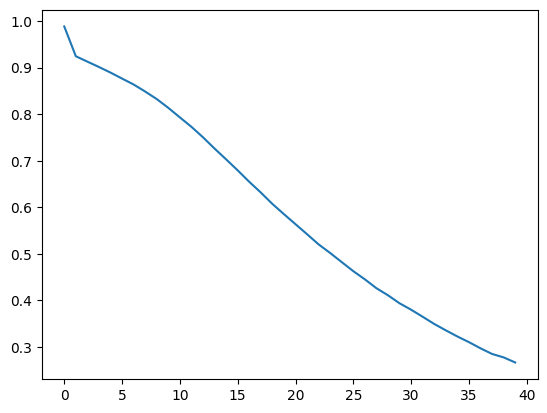

In [244]:
# Plot the graph brother
plt.plot(loss_collection)

# torch.argmax(torch.tensor([[0,1,2], [0,3,2], [1,5,2], [0,-1,2], [0,1,1]]), dim=1)

In [245]:
preds = []
actual = []
total = 0
with torch.no_grad():
    for data in train_dataloader:
        inputs, labels = data
        actual += labels.tolist()
        outputs = network(inputs)
        pred = torch.argmax(outputs, dim=1)
        total += len(inputs)
        preds += pred.tolist()


In [246]:
cwise_acc = []
for idx, age in enumerate(["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]):
    age_mask = np.array(actual) == idx
    y_true = np.array(actual)[age_mask]
    y_rel_preds = np.array(preds)[age_mask]
    age_acc = np.sum(y_true == y_rel_preds) / len(y_true) * 100
    cwise_acc.append(age_acc)
    print(f"NN + CLIP accuracy for {age}(class-{idx}): {age_acc:.2f}%")

NN + CLIP accuracy for 0-2(class-0): 96.15%
NN + CLIP accuracy for 3-9(class-1): 97.03%
NN + CLIP accuracy for 10-19(class-2): 92.71%
NN + CLIP accuracy for 20-29(class-3): 91.83%
NN + CLIP accuracy for 30-39(class-4): 89.53%
NN + CLIP accuracy for 40-49(class-5): 93.20%
NN + CLIP accuracy for 50-59(class-6): 79.77%
NN + CLIP accuracy for 60-69(class-7): 91.15%
NN + CLIP accuracy for more than 70(class-8): 97.86%


In [247]:
preds = []
actual = []
total = 0
with torch.no_grad():
    for data in val_dataloader:
        inputs, labels = data
        actual += labels.tolist()
        outputs = network(inputs)
        pred = torch.argmax(outputs, dim=1)
        total += len(inputs)
        preds += pred.tolist()

In [248]:
val_acc = np.sum(np.array(preds) == np.array(actual)) / total
print(f"Validation accuracy for Age: {val_acc*100:.4f}%")

Validation accuracy for Age: 52.1910%


In [249]:
val_cwise_acc_nn = []
for idx, age in enumerate(["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]):
    age_mask = np.array(actual) == idx
    y_true = np.array(actual)[age_mask]
    y_rel_preds = np.array(preds)[age_mask]
    age_acc = np.sum(y_true == y_rel_preds) / len(y_true) * 100
    val_cwise_acc_nn.append(age_acc)
    print(f"NN + CLIP accuracy for {age}(class-{idx}): {age_acc:.2f}%")

NN + CLIP accuracy for 0-2(class-0): 74.37%
NN + CLIP accuracy for 3-9(class-1): 75.88%
NN + CLIP accuracy for 10-19(class-2): 43.78%
NN + CLIP accuracy for 20-29(class-3): 57.82%
NN + CLIP accuracy for 30-39(class-4): 45.36%
NN + CLIP accuracy for 40-49(class-5): 45.82%
NN + CLIP accuracy for 50-59(class-6): 30.15%
NN + CLIP accuracy for 60-69(class-7): 44.55%
NN + CLIP accuracy for more than 70(class-8): 46.61%


# Measuring LR and ZS performance

In [ ]:
lr_clf_age = LogisticRegression(random_state=42, max_iter=400)
lr_clf_age.fit(X_train, y_train_age)

LogisticRegression(max_iter=400, random_state=42)

In [61]:
train_acc = lr_clf_age.score(X_train, y_train_age)
val_acc = lr_clf_age.score(X_val, y_val_age)
print(f"Training accuracy for Age: {train_acc*100:.4f}%")
print(f"Validation accuracy for Age: {val_acc*100:.4f}%")

Training accuracy for Age: 61.4636%
Validation accuracy for Age: 61.1010%


In [62]:
# Distribution of age categories
print("Distribution of Age Categories in FairFace")
distribution_of_ages  = []
cat, counts = np.unique(y_train_age, return_counts=True)
total_counts = np.sum(counts)
pcts = []
for idx, c in enumerate(["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]):
    pct = counts[idx]/total_counts*100
    print(f"{c} - {pct : .2f}%")
    pcts.append(pct)

Distribution of Age Categories in FairFace
0-2 -  2.07%
3-9 -  12.00%
10-19 -  10.49%
20-29 -  29.51%
30-39 -  22.19%
40-49 -  12.39%
50-59 -  7.18%
60-69 -  3.20%
more than 70 -  0.97%


In [63]:
# y_preds = lr_clf_gender.predict(X_train)
# from sklearn.metrics import precision_recall_fscore_support
# precision_recall_fscore_support(y_train_gender, y_preds, average='micro')

In [64]:
# train_acc = lr_clf_race.score(X_train, y_train_race)
# val_acc = lr_clf_race.score(X_val, y_val_race)
# print(f"Training accuracy for race: {train_acc*100:.4f}%")
# print(f"Validation accuracy for race: {val_acc*100:.4f}%")

In [65]:
y_preds = lr_clf_age.predict(X_train)
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(y_train_age, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(y_train_age, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(y_train_age, y_preds, average='micro')
train_acc = lr_clf_age.score(X_train, y_train_age)
print(f"Training set metrics - Age (LR + CLIP) \n" + "="*40)
print(f"Accuracy: {train_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Training set metrics - Age (LR + CLIP) 
Accuracy: 0.6146 Precision: 0.6096, Recall: 0.6146, F-Score(Weighted): 0.6083, F-Score(Micro): 0.6146, F-Score(Macro): 0.5894


In [66]:
cwise_acc = []
for idx, age in enumerate(["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]):
    age_mask = np.array(y_train_age) == idx
    y_true = np.array(y_train_age)[age_mask]
    y_rel_preds = np.array(y_preds)[age_mask]
    age_acc = np.sum(y_true == y_rel_preds) / len(y_true) * 100
    cwise_acc.append(age_acc)
    print(f"LR+CLIP accuracy for {age}(class-{idx}): {age_acc:.2f}%")

LR+CLIP accuracy for 0-2(class-0): 68.69%
LR+CLIP accuracy for 3-9(class-1): 86.75%
LR+CLIP accuracy for 10-19(class-2): 44.22%
LR+CLIP accuracy for 20-29(class-3): 75.60%
LR+CLIP accuracy for 30-39(class-4): 51.50%
LR+CLIP accuracy for 40-49(class-5): 46.84%
LR+CLIP accuracy for 50-59(class-6): 50.87%
LR+CLIP accuracy for 60-69(class-7): 43.94%
LR+CLIP accuracy for more than 70(class-8): 41.09%


In [67]:
y_preds = lr_clf_age.predict(X_val)
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(y_val_age, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(y_val_age, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(y_val_age, y_preds, average='micro')
val_acc = lr_clf_age.score(X_val, y_val_age)
print(f"Validation set metrics - Age (LR + CLIP)\n" + "="*40)
print(f"Accuracy: {val_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Validation set metrics - Age (LR + CLIP)
Accuracy: 0.6110 Precision: 0.6053, Recall: 0.6110, F-Score(Weighted): 0.6045, F-Score(Micro): 0.6110, F-Score(Macro): 0.5740


In [68]:
val_cwise_acc=[]
for idx, age in enumerate(["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]):
    age_mask = np.array(y_val_age) == idx
    y_true = np.array(y_val_age)[age_mask]
    y_rel_preds = np.array(y_preds)[age_mask]
    age_acc = np.sum(y_true == y_rel_preds) / len(y_true) * 100
    val_cwise_acc.append(age_acc)
    print(f"LR+CLIP accuracy for {age}(class-{idx}): {age_acc:.2f}%")

LR+CLIP accuracy for 0-2(class-0): 71.36%
LR+CLIP accuracy for 3-9(class-1): 86.36%
LR+CLIP accuracy for 10-19(class-2): 44.03%
LR+CLIP accuracy for 20-29(class-3): 75.12%
LR+CLIP accuracy for 30-39(class-4): 51.03%
LR+CLIP accuracy for 40-49(class-5): 46.56%
LR+CLIP accuracy for 50-59(class-6): 46.48%
LR+CLIP accuracy for 60-69(class-7): 48.91%
LR+CLIP accuracy for more than 70(class-8): 29.66%


In [69]:
y_preds = valid_ds["zs_age_clip"]
precision, recall, f_score_weighted, _ = precision_recall_fscore_support(y_val_age, y_preds, average='weighted')
_, _, f_score_macro, _ = precision_recall_fscore_support(y_val_age, y_preds, average='macro')
_, _, f_score_micro, _ = precision_recall_fscore_support(y_val_age, y_preds, average='micro')
val_acc = lr_clf_age.score(X_val, y_val_age)
print(f"Validation set metrics - Age (Zero-Shot CLIP)\n" + "="*40)
print(f"Accuracy: {val_acc:.4f} Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score(Weighted): {f_score_weighted:.4f}, F-Score(Micro): {f_score_micro:.4f}, F-Score(Macro): {f_score_macro:.4f}")

Validation set metrics - Age (Zero-Shot CLIP)
Accuracy: 0.6110 Precision: 0.4782, Recall: 0.3984, F-Score(Weighted): 0.4110, F-Score(Micro): 0.3984, F-Score(Macro): 0.3714


In [70]:
val_cwise_zs_acc=[]
for idx, age in enumerate(["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]):
    age_mask = np.array(y_val_age) == idx
    y_true = np.array(y_val_age)[age_mask]
    y_rel_preds = np.array(y_preds)[age_mask]
    age_acc = np.sum(y_true == y_rel_preds) / len(y_true) * 100
    val_cwise_zs_acc.append(age_acc)
    print(f"Zero-Shot CLIP accuracy for {age}(class-{idx}): {age_acc:.2f}%")

Zero-Shot CLIP accuracy for 0-2(class-0): 76.38%
Zero-Shot CLIP accuracy for 3-9(class-1): 57.08%
Zero-Shot CLIP accuracy for 10-19(class-2): 58.00%
Zero-Shot CLIP accuracy for 20-29(class-3): 27.70%
Zero-Shot CLIP accuracy for 30-39(class-4): 50.56%
Zero-Shot CLIP accuracy for 40-49(class-5): 23.95%
Zero-Shot CLIP accuracy for 50-59(class-6): 23.24%
Zero-Shot CLIP accuracy for 60-69(class-7): 17.45%
Zero-Shot CLIP accuracy for more than 70(class-8): 81.36%


In [73]:
age_cats = ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]
results_df = pd.DataFrame({
    "Age Group": age_cats, 
    "Distribution": pcts, 
    "Training Accuracy": cwise_acc, 
    "Validation Accuracy": val_cwise_acc, 
    "Validation ZS Accuracy": val_cwise_zs_acc
    } )
results_df["Percent improvement"] = results_df["Validation Accuracy"] - results_df["Validation ZS Accuracy"] 
results_df

,Age Group,Distribution,Training Accuracy,Validation Accuracy,Validation ZS Accuracy,Percent improvement
0,0-2,2.065849,68.694196,71.356784,76.381910,-5.025126
1,3-9,11.998524,86.750576,86.356932,57.079646,29.277286
2,10-19,10.494098,44.216192,44.030483,58.001693,-13.971211
3,20-29,29.509822,75.595750,75.121212,27.696970,47.424242
4,30-39,22.191737,51.496104,51.030043,50.557940,0.472103
5,40-49,12.385871,46.835443,46.563193,23.946785,22.616408
6,50-59,7.179747,50.867052,46.482412,23.241206,23.241206
7,60-69,3.203680,43.936668,48.909657,17.445483,31.464174
8,more than 70,0.970672,41.092637,29.661017,81.355932,-51.694915


In [29]:
# Save Emotion model
joblib.dump(lr_clf_age, '../models/lr_clf_age.joblib')
print("Model saved successfully!")
# To load the model from the file later
clf_age_loaded = joblib.load('../models/lr_clf_age.joblib')
print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!
